In [103]:
#Python libraries

!pip install tf2onnx


import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [63]:
#check tensorflow version
print(tf.__version__)

2.13.0


In [64]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

False


In [65]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [66]:
terminal_info=mt5.terminal_info()

In [67]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"

In [68]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]

In [69]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2023-05-16 23:00:56.481325
data end date= 2023-09-13 23:00:56.481325


In [70]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [71]:
#check
print(eurusd_rates)

[(1684292400, 1.08654, 1.08718, 1.08639, 1.08705, 1363, 1, 0)
 (1684296000, 1.08704, 1.08711, 1.08621, 1.08698, 1841, 1, 0)
 (1684299600, 1.08699, 1.08734, 1.08683, 1.08697, 1123, 1, 0) ...
 (1694649600, 1.07272, 1.073  , 1.07272, 1.07287,  605, 5, 0)
 (1694653200, 1.07288, 1.07343, 1.07285, 1.0733 ,  512, 1, 0)
 (1694656800, 1.0733 , 1.07347, 1.07305, 1.07329,  369, 1, 0)]


In [72]:
#create dataframe
df = pd.DataFrame(eurusd_rates)

In [73]:
#show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1684292400,1.08654,1.08718,1.08639,1.08705,1363,1,0
1,1684296000,1.08704,1.08711,1.08621,1.08698,1841,1,0
2,1684299600,1.08699,1.08734,1.08683,1.08697,1123,1,0
3,1684303200,1.08697,1.08712,1.08645,1.08655,908,1,0
4,1684306800,1.08654,1.08677,1.08631,1.08647,861,1,0


In [74]:
#show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
2059,1694642400,1.07321,1.07324,1.07280,1.07318,1536,1,0
2060,1694646000,1.07318,1.07320,1.07283,1.07283,700,1,0
2061,1694649600,1.07272,1.07300,1.07272,1.07287,605,5,0
2062,1694653200,1.07288,1.07343,1.07285,1.07330,512,1,0
2063,1694656800,1.07330,1.07347,1.07305,1.07329,369,1,0


In [75]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(2064, 8)

In [76]:
#prepare close prices only
data = df.filter(['close']).values

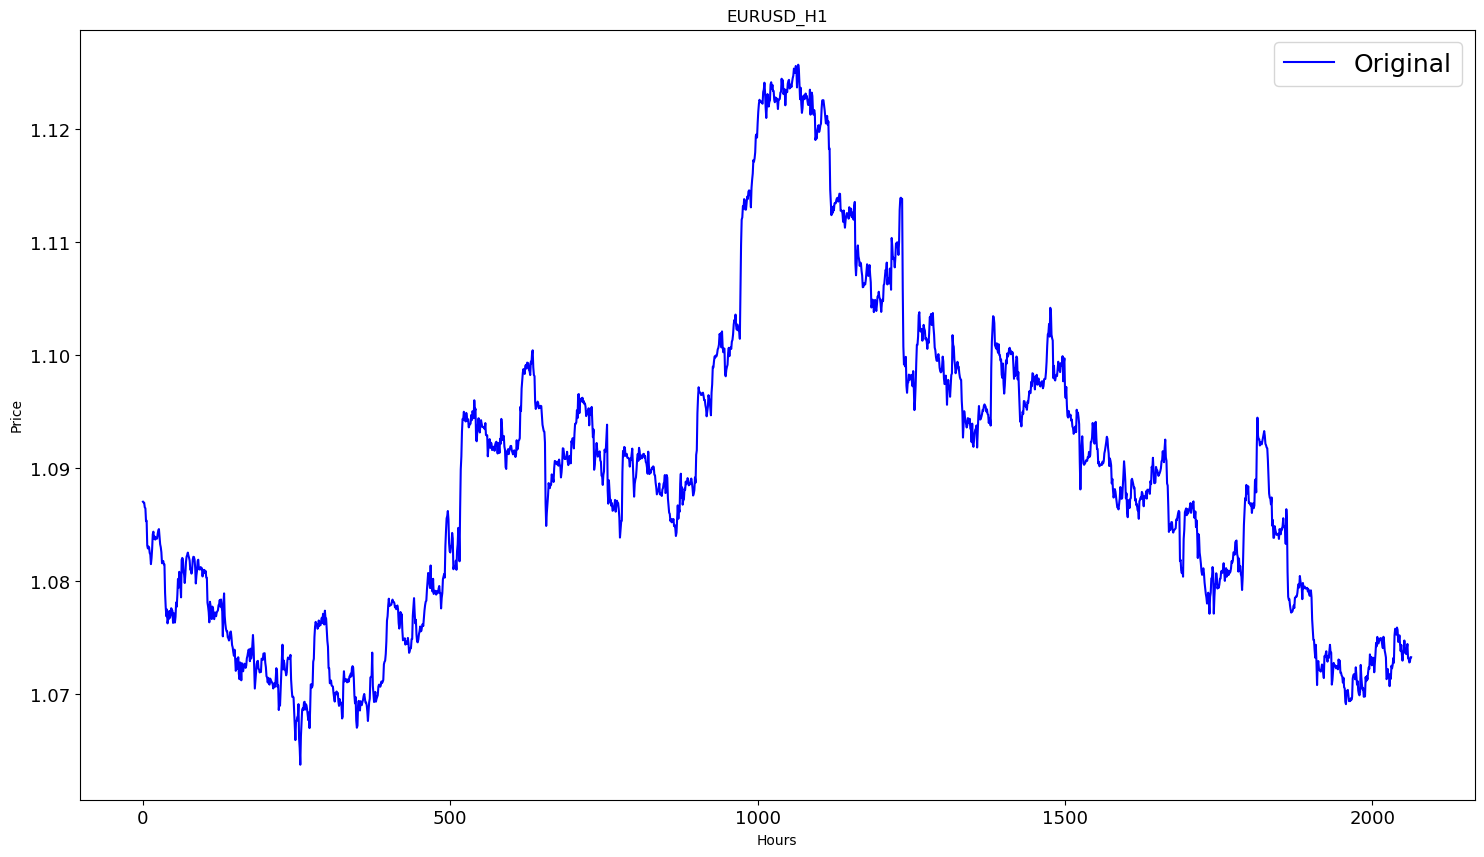

In [77]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.xticks(fontsize=13)
plt.ylabel("Price")
plt.yticks(fontsize=13)
plt.title("EURUSD_H1")
plt.legend(fontsize=18)

In [78]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [79]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1651


In [80]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1651


In [81]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

413


In [82]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [83]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

In [84]:
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [85]:
#show shape of train data
x_train.shape

(1531, 120, 1)

In [86]:
#show shape of test data
x_test.shape

(293, 120, 1)

In [87]:
#import keras libraries for the model

!pip install keras

import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
#from keras.utils.vis_utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [88]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [89]:
#show model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 60, 256)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 60, 100)           142800    
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [90]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/300
48/48 [==============================] - 37s 411ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 2/300
48/48 [==============================] - 17s 355ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 3/300
48/48 [==============================] - 12s 260ms/step - loss: 0.0029 - root_mean_squared_error: 0.0534 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 4/300
48/48 [==============================] - 15s 311ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0394
Epoch 5/300
48/48 [==============================] - 13s 268ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 6/300
48/48 [==============================] - 12s 259ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0

In [91]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

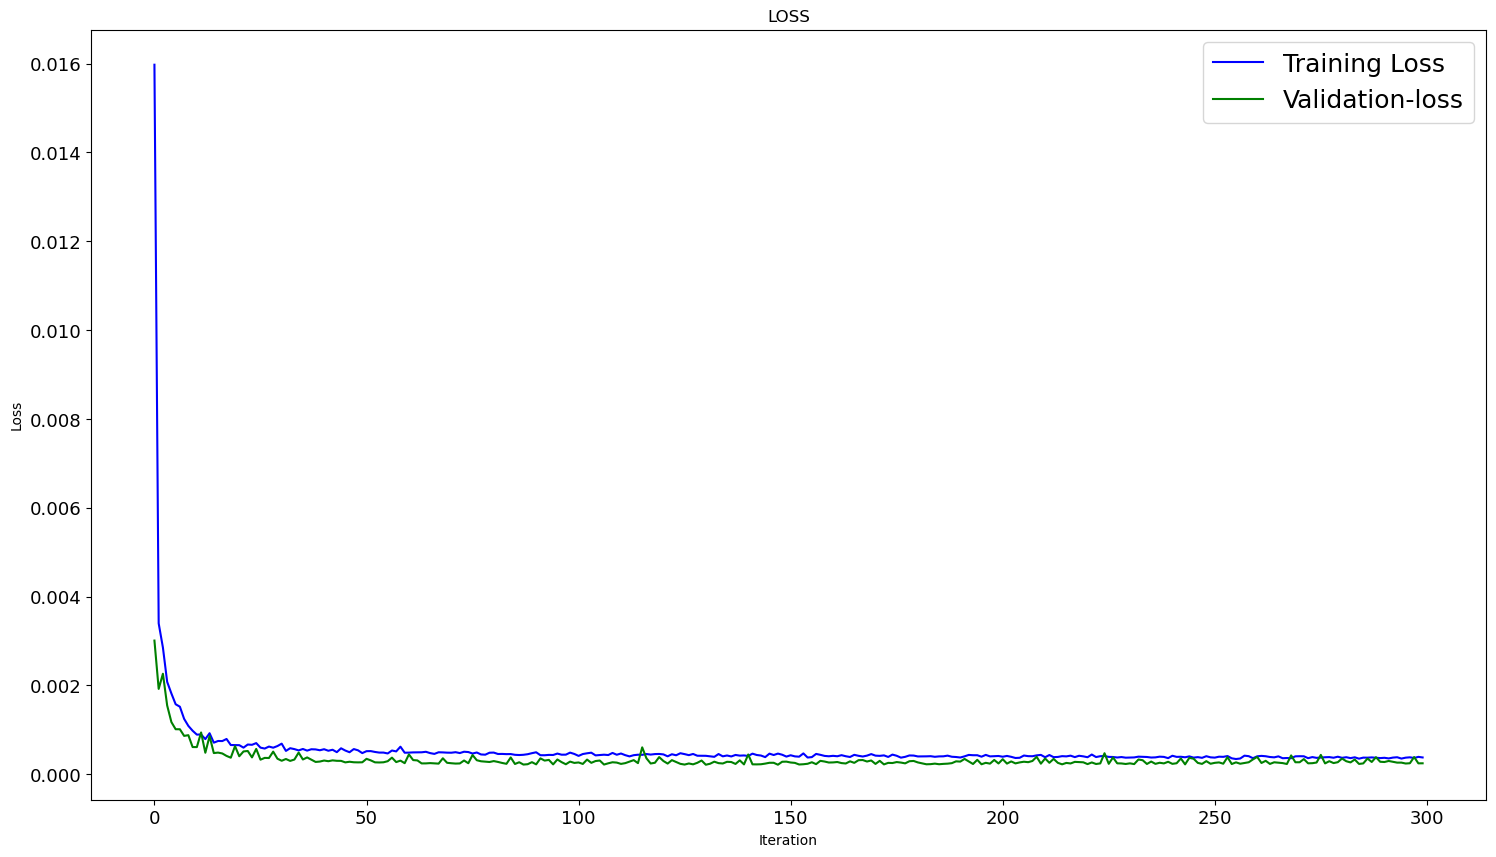

In [92]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("LOSS")
plt.legend(fontsize=18)

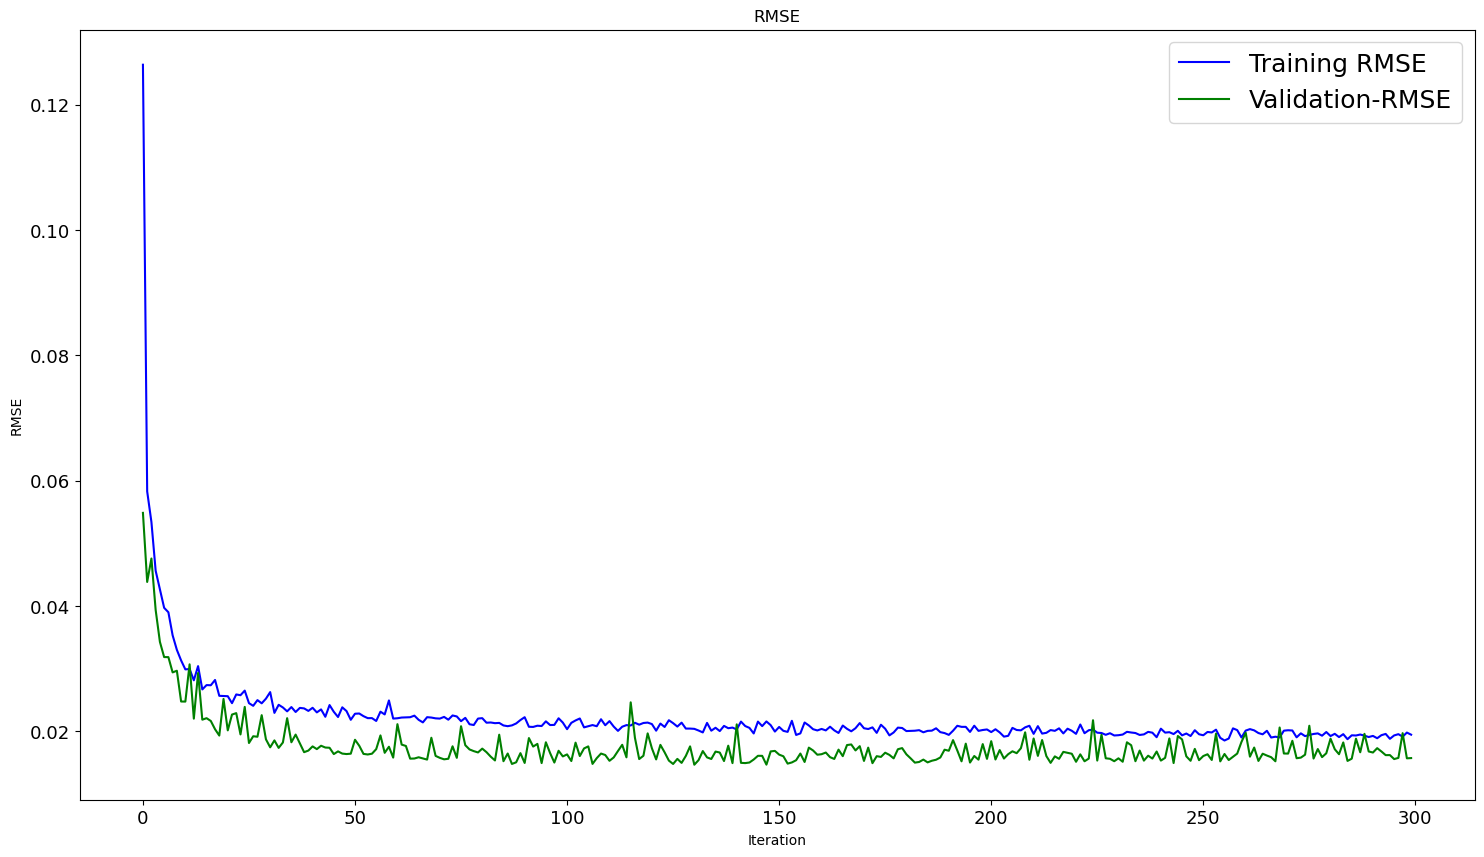

In [93]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation-RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("RMSE")
plt.legend(fontsize=18)

In [94]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

48/48 [==============================] - 4s 78ms/step - loss: 2.1720e-04 - root_mean_squared_error: 0.0147


[0.00021720035874750465, 0.014737718738615513]

In [95]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

10/10 [==============================] - 1s 74ms/step - loss: 2.4724e-04 - root_mean_squared_error: 0.0157


[0.0002472390478942543, 0.015723837539553642]

In [96]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

48/48 [==============================] - 7s 77ms/step


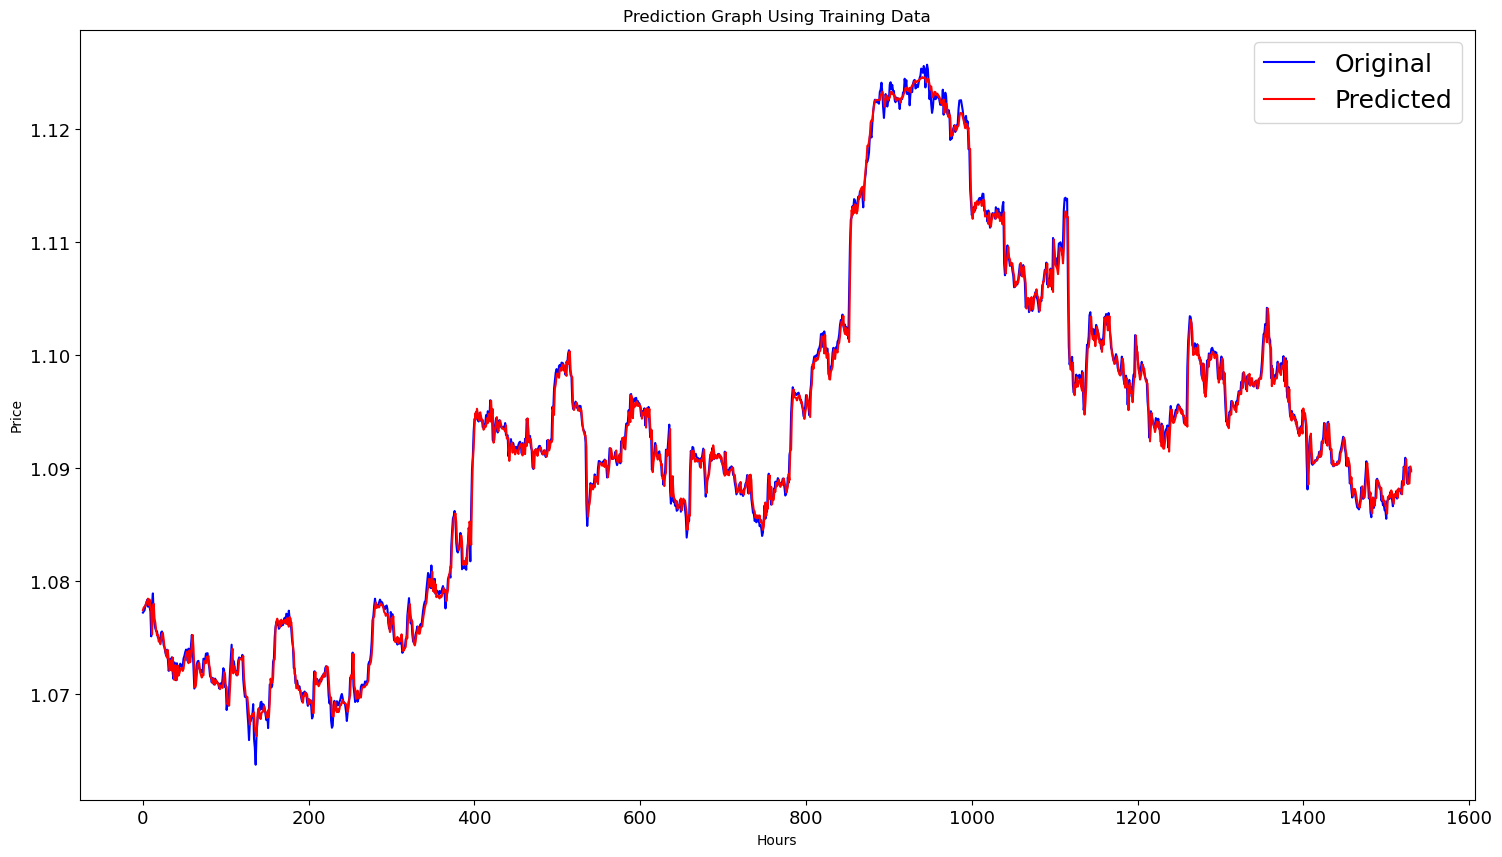

In [97]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [98]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

10/10 [==============================] - 1s 60ms/step


In [99]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.0009739368257226394
MSE          : 9.485529404986908e-07
R2 score     : 0.9784344534073387


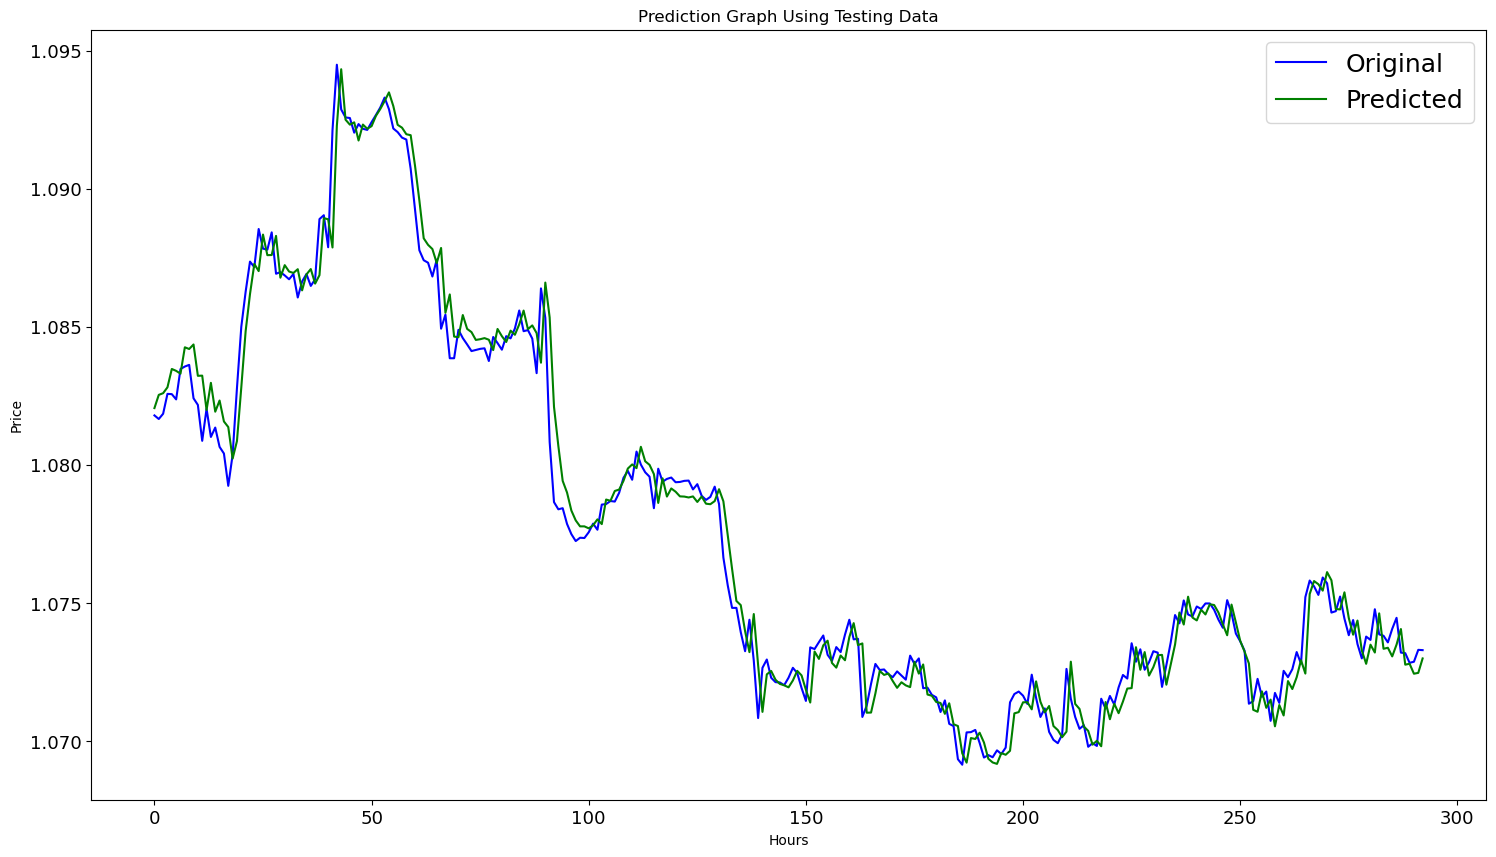

In [100]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [101]:
# save model to ONNX
output_path = data_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.


In [102]:
# finish
mt5.shutdown()

True